Preamble to enable plotting
===

In [1]:
%matplotlib inline

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import itertools


First Plot
========

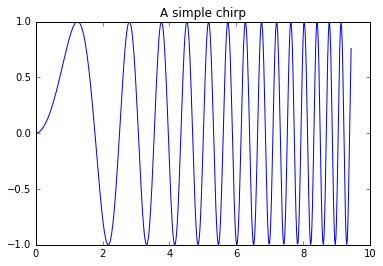

In [4]:
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp');

In [3]:
class Point:
    """A 2 dimensional point"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return "Point("+str(self.x)+","+str(self.y)+")"

In [4]:
class Box:
    def __init__(self, center, width):
        self.center = center
        self.width = width
    def divide(self, function):
        new_width = self.width / 3
        left_x = self.center.x - self.width/2 + new_width/2
        left = Box(Point(left_x, function(left_x)), new_width)
        right_x = self.center.x + self.width/2 - new_width/2
        right = Box(Point(right_x, function(right_x)), new_width)
        
        return (left, Box(self.center, new_width), right)
    def __repr__(self):
        return "Box("+str(self.center)+","+str(self.width)+")"

In [5]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [32]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return itertools.izip(a, b)

In [41]:
def lipschitzControlPoints(numPoints, K):
    """The control points for a piecewise linear function on 0..1 whose Lipschitz constant is at most K
    
       return a sequence of Point objects that when connected by lines form a Lipschitz continuous function whose
       constant is at most K and whose first point is chosen uniformly in the interval [0,1]
    
       numPoints the number of points to generate: must be 2 or more
    
       K   the constant such that abs(x0-x1) <= k(f(x0)-f(x1))
    """
    def nextPt(x, y, newx):
        """Choose a random y value for the next point meeting the Lipschitz condition """
        dx = abs(newx-x)
        maxy = y + dx*K
        miny = y - dx*K
        return rng.uniform(miny, maxy)
    
    xval=[0,1];xval.extend([rng.uniform(0,1) for i in range(1,numPoints-2)])
    xval.sort()
    yval = [0] * len(xval)
    yval[0] = rng.uniform(0,1)
    for i in range(1,len(xval)):
        yval[i] = nextPt(xval[i-1], yval[i-1], xval[i])
    return [Point(i[0], i[1]) for i in zip(xval, yval)]
    

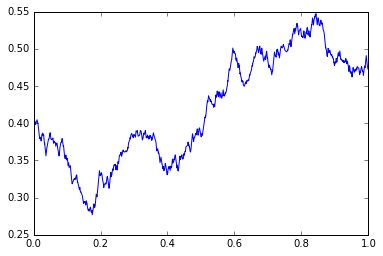

In [76]:
cp=lipschitzControlPoints(1000,5)
plt.plot([p.x for p in cp],[p.y for p in cp])

In [47]:
b=Box(Point(0,0),18)

In [51]:
b

Box(Point(0,0),18)

In [54]:
xsq=lambda x:x*x

In [63]:
divided = b.divide(xsq)

In [64]:
divided

(Box(Point(-6.0,36.0),6.0), Box(Point(0,0),6.0), Box(Point(6.0,36.0),6.0))

In [65]:
divided = flatten([x.divide(xsq) for x in divided])

In [66]:
divided

[Box(Point(-8.0,64.0),2.0),
 Box(Point(-6.0,36.0),2.0),
 Box(Point(-4.0,16.0),2.0),
 Box(Point(-2.0,4.0),2.0),
 Box(Point(0,0),2.0),
 Box(Point(2.0,4.0),2.0),
 Box(Point(4.0,16.0),2.0),
 Box(Point(6.0,36.0),2.0),
 Box(Point(8.0,64.0),2.0)]